# Arabic Font Classification
This notebook is insprired from Mahmoud Aslan's work on Arabic Font Classification.

## Imports

In [15]:
import transformers
import torch
torch.cuda.is_available()

True

In [16]:
import numpy as np
import random as rn
import os
import tensorflow as tf

#gpu tensorflow
tf.config.experimental.set_visible_devices([], 'GPU')

rn.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
rng = tf.random.experimental.Generator.from_seed(1234)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(0)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''


## Load data

In [17]:
from pathlib import Path
RUFA_PATH = Path('../data/rufa/')

In [18]:
synth_dir = Path.joinpath(RUFA_PATH, 'synth')
real_dir = Path.joinpath(RUFA_PATH, 'real')

CLASS_NAMES = np.array([item.name for item in real_dir.glob('*')])
CLASS_NAMES

array(['farsi', 'ruqaa'], dtype='<U5')

In [19]:
synth_paths = tf.data.Dataset.list_files(str(synth_dir / '*/*.jpg'), seed=42)
real_paths = tf.data.Dataset.list_files(str(real_dir / '*/*.jpg'), seed=42)

## Train, val, mismatch, test split

In [20]:
_max_data_size = 2**32
_test_ratio = 0.2


def test_set_check(item):
    id = tf.strings.split(tf.strings.split(item, os.sep)[-1], '.')[0]
    hash = tf.strings.to_hash_bucket_fast(id, _max_data_size)
    return tf.cast(hash, tf.float64) < _test_ratio * _max_data_size

def train_set_check(item):
    id = tf.strings.split(tf.strings.split(item, os.sep)[-1], '.')[0]
    hash = tf.strings.to_hash_bucket_fast(id, _max_data_size)
    return tf.cast(hash, tf.float64) >= _test_ratio * _max_data_size

In [21]:
train_paths = synth_paths.filter(train_set_check)
val_paths = synth_paths.filter(test_set_check)
mismatch_paths = real_paths.filter(test_set_check)
test_paths = real_paths.filter(train_set_check)

## Preprocessing

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
mapping = {0: 'farsi', 1: 'ruqaa'}

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size, seed=42)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def parse_image(data_instance):
  parts = tf.strings.split(data_instance, os.sep)
  label = tf.cast(tf.argmax(tf.cast(parts[-2] == np.array(list(mapping.values())), dtype=tf.float16)), tf.float16)

  image = tf.io.read_file(data_instance)
  image = tf.image.decode_jpeg(image, 1)
  image = tf.image.convert_image_dtype(image, tf.float32)

  if parts[-3] == 'synth':
    noise = rng.normal(shape=tf.shape(image), mean=0.0, stddev=0.015, dtype=tf.float32)
    image = tf.add( image, noise)
    image = tf.clip_by_value(image, 0.0, 1.0)

    image = tf.image.adjust_jpeg_quality(image, 90)

  return image, label

In [23]:
train_ds = train_paths.map(parse_image)
val_ds = val_paths.map(parse_image)
mismatch_ds = mismatch_paths.map(parse_image)
full_train_ds = train_ds.concatenate(val_ds.concatenate(mismatch_ds))
test_ds = test_paths.map(parse_image)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
mismatch_ds = prepare_for_training(mismatch_ds)
full_train_ds = prepare_for_training(full_train_ds)
test_ds = prepare_for_training(test_ds)

## Model

In [24]:
def cnn(input_shape, output_shape):
    num_classes = output_shape[0]
    dropout_seed = 708090
    kernel_seed = 42
  
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1, seed=dropout_seed),
      tf.keras.layers.Conv2D(32, 5, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1, seed=dropout_seed),
      tf.keras.layers.Conv2D(64, 10, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1, seed=dropout_seed),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed)),
      tf.keras.layers.Dropout(0.2, seed=dropout_seed),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed)),
      tf.keras.layers.Dropout(0.2, seed=dropout_seed),
      tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=kernel_seed))
    ])

    return model

In [25]:
epochs = 6
callbacks = None

In [26]:
model = cnn((100, 100, 1), (1,))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='Adam', metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 49, 49, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 22, 22, 32)       

## Training and evaluation

In [31]:
# !wget 'https://raw.githubusercontent.com/mhmoodlan/arabic-font-classification/master/codebase/code/font_classifier/weights/FontModel_RuFaDataset_cnn_weights(4).h5' -O weights.h5
model.load_weights('../scripts/acsr_apps/weights.h5')

In [14]:
model.fit(
  full_train_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/6
1254/1254 [==============================] - 667s 530ms/step - loss: 0.3897 - accuracy: 0.8245
Epoch 2/6
  79/1254 [>.............................] - ETA: 13:26 - loss: 0.0787 - accuracy: 0.9885

KeyboardInterrupt: 

#### Evaluate

In [32]:
test_score = model.evaluate(test_ds)
print(f"Test score: {test_score}")

14/14 [==============================] - 2s 113ms/step - loss: 0.2316 - accuracy: 0.9712 0.2339 - accuracy: 0.97
Test score: [0.231625497341156, 0.971222996711731]


In [33]:
assert np.allclose(test_score, [.231625, .971222])

#### test 

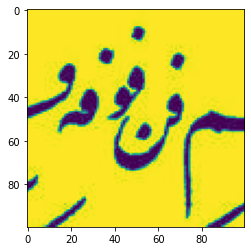

In [101]:
import matplotlib.pyplot as plt

for i in test_ds:
  A = i
  break
img = A[0].numpy()[0, :, :, 0]
label = A[1].numpy()[0]
plt.imshow(img)
plt.show()

#### Saliency maps

In [102]:
inp = tf.convert_to_tensor(
    img[None, :, :, None],
    dtype = tf.float32
)
inp_var = tf.Variable(inp)

print("logit for this img : {:.3f}".format(float(model(inp_var))), " Ground truth : {:.0f}".format(label))

logit for this img : 1.000  Ground truth : 0


In [103]:
with tf.GradientTape() as tape:
    pred = model(inp_var, training=False)
    loss = pred[0][0]
grads = tape.gradient(loss, inp_var)

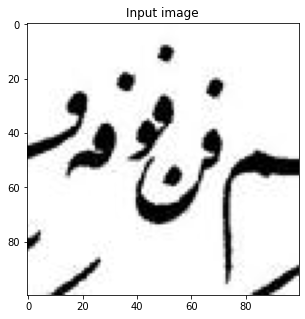

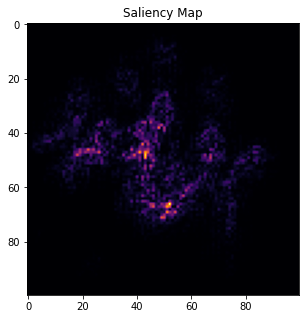

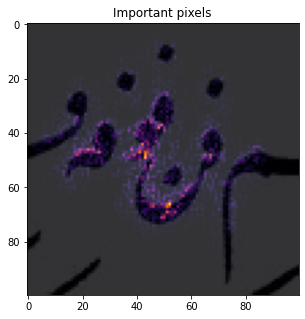

In [104]:
plt.figure(figsize=(12, 5))
plt.imshow(img, cmap="gray")
# plt.colorbar()
plt.title("Input image")


plt.figure(figsize=(12, 5))
plt.imshow(np.abs(grads.numpy()[0,:,:,0]), cmap="inferno")
# plt.colorbar()
plt.title("Saliency Map")
plt.show()

grads_normalized = tf.math.abs(grads) / tf.math.reduce_max(tf.math.abs(grads))
# img_with_saliency_map = grads_normalized[0, :, :, 0] * img


plt.figure(figsize=(12, 5))
plt.imshow(img, cmap="gray")
plt.imshow(np.abs(grads_normalized[0,:,:,0]), alpha=0.8, cmap="inferno")
# plt.colorbar()
plt.title("Important pixels")
plt.show()


In [105]:
def saliency_map(img):
    """
    return the normalized gradients overs the image, and also the prediction of the model
    """
    inp = tf.convert_to_tensor(
        img[None, :, :, None],
        dtype = tf.float32
    )
    inp_var = tf.Variable(inp)

    with tf.GradientTape() as tape:
        pred = model(inp_var, training=False)
        loss = pred[0][0]
    grads = tape.gradient(loss, inp_var)
    
    return grads, round(float(model(inp_var, training = False)))

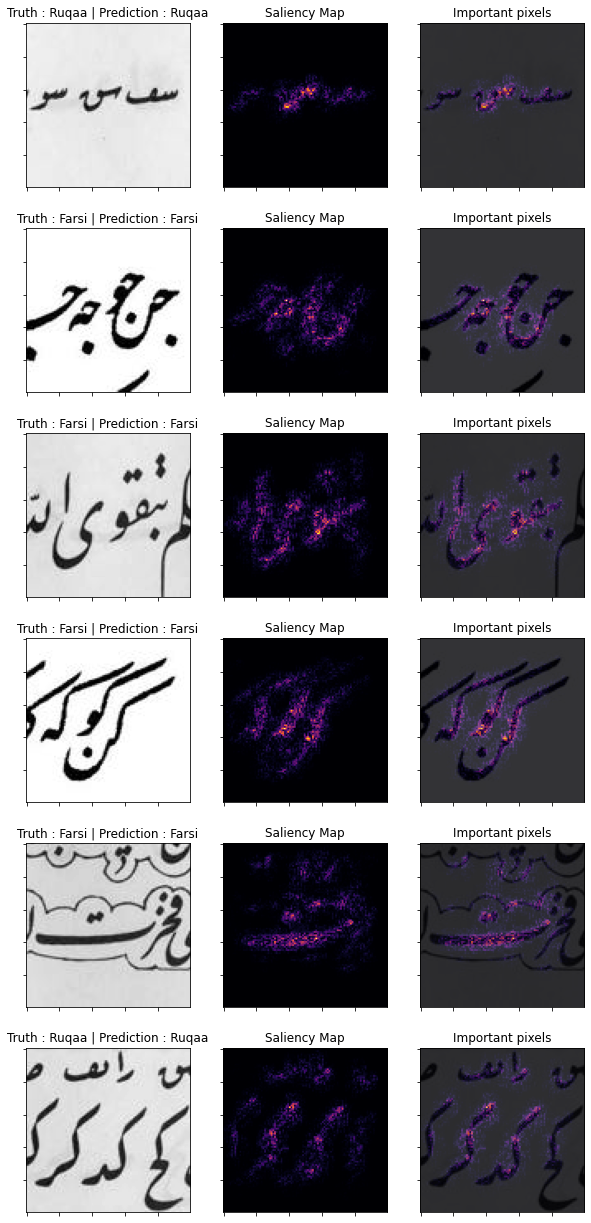

In [115]:
# plot in table
id_to_label = {
    0 : "Farsi",
    1 : "Ruqaa"
}
fig, axs = plt.subplots(6, 3, figsize=(10, 22))

# for A in test_ds:
#     break

for i in range(6):
    img = A[0].numpy()[i, :, :, 0]
    label = A[1].numpy()[i]

    grads, prediction = saliency_map(img)

    axs[i, 0].imshow(img, cmap="gray")
    axs[i, 0].set_title("Truth : " + id_to_label[label] + " | Prediction : " + id_to_label[prediction])
    axs[i, 0].set_yticklabels([])
    axs[i, 0].set_xticklabels([])

    axs[i, 1].imshow(np.abs(grads.numpy()[0,:,:,0]), cmap="inferno")
    axs[i, 1].set_title("Saliency Map")
    axs[i, 1].set_yticklabels([])
    axs[i, 1].set_xticklabels([])

    axs[i, 2].imshow(img, cmap="gray")
    axs[i, 2].imshow(np.abs(grads.numpy()[0,:,:,0]), alpha=0.8, cmap="inferno")
    axs[i, 2].set_title("Important pixels")
    axs[i, 2].set_yticklabels([])
    axs[i, 2].set_xticklabels([])

fig.savefig("../assets/saliency_maps.png", dpi = 300)
    